Notebook to apply object detection model to a ground truth TFRecord, process results and calculate confusion matrix, precision and recall

Based on scripts from:

Object detection process adapted from https://github.com/tensorflow/models/blob/master/research/object_detection/inference/infer_detections.py

Confusion matrix code adapted from https://github.com/svpino/tf_object_detection_cm/blob/master/confusion_matrix.py



In [1]:
import numpy as np
import os,time
from object_detection.utils import label_map_util
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
import tensorflow.compat.v1 as tf
from object_detection.inference import detection_inference

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
def compute_iou(groundtruth_box, detection_box):
    g_ymin, g_xmin, g_ymax, g_xmax = tuple(groundtruth_box)
    d_ymin, d_xmin, d_ymax, d_xmax = tuple(detection_box)
    
    xa = max(g_xmin, d_xmin)
    ya = max(g_ymin, d_ymin)
    xb = min(g_xmax, d_xmax)
    yb = min(g_ymax, d_ymax)

    intersection = max(0, xb - xa + 1) * max(0, yb - ya + 1)

    boxAArea = (g_xmax - g_xmin + 1) * (g_ymax - g_ymin + 1)
    boxBArea = (d_xmax - d_xmin + 1) * (d_ymax - d_ymin + 1)

    return intersection / float(boxAArea + boxBArea - intersection)

In [4]:

def display(confusion_matrix, categories, output_path,METRICS_TITLE):
    '''
    Displays confusion matrix as pandas df to terminal and saves as CSV
    Args:
      confusion_matrix: matrix to be displayed
      categories: ordered array of class IDs
      output_path: where to save CSV
    '''
    print(METRICS_TITLE)
    #print('\nConfusion Matrix:')
    #print(confusion_matrix, '\n')
    results = []

    for i in range(len(categories)):
        id = categories[i]['id'] - 1
        name = categories[i]['name']
        
        total_target = np.sum(confusion_matrix[id,:])
        total_predicted = np.sum(confusion_matrix[:,id])
        
        precision = float(confusion_matrix[id, id] / total_predicted)
        recall = float(confusion_matrix[id, id] / total_target)
        
        results.append({'category' : name, f'precision_@{IOU_THRESHOLD}IOU' : precision, f'recall_@{IOU_THRESHOLD}IOU' : recall})
    
    df = pd.DataFrame(results)
    print ("Precision/recall Table")
    print(df)
    df.to_csv(output_path,mode='a')
    


In [5]:
#plot confusion matrix with matpolotlib/seaborn

def plot_confusion(confusion_matrix, categories,output_path):
    label_list=[]
    for label in categories:
        label_list.append(label["name"])
    #print(label_list)

    conf_mat_df=pd.DataFrame(confusion_matrix, columns=label_list+["FN"],index=label_list+["FP"])
    print(conf_mat_df)
    conf_mat_df.to_csv(output_path,mode='a')
    figure = plt.figure(figsize=(8, 8))
## Ticket labels - List must be in alphabetical order

    ax=sns.heatmap(conf_mat_df, annot=True,cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.tick_top()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
def run_inference(GROUND_TRUTH_TFRECORD,MODEL_FILE,DETECTION_TFRECORD):
    tf.logging.set_verbosity(tf.logging.INFO)

    with tf.Session() as sess:
        input_tfrecord_paths = [
            v for v in GROUND_TRUTH_TFRECORD.split(',') if v]
        print('Reading input from ', GROUND_TRUTH_TFRECORD)
        serialized_example_tensor, image_tensor = detection_inference.build_input(
                    input_tfrecord_paths)
        #tf.logging.info('Reading graph and building model...')
        (detected_boxes_tensor, detected_scores_tensor,
         detected_labels_tensor) = detection_inference.build_inference_graph(
             image_tensor, MODEL_FILE)

       # tf.logging.info('Running inference and writing output to {}'.format(
        #    DETECTION_TFRECORD))
        sess.run(tf.local_variables_initializer())
        tf.train.start_queue_runners()
        with tf.python_io.TFRecordWriter(
            DETECTION_TFRECORD) as tf_record_writer:
              try:
                counter=0
                start=time.time()
                for counter in itertools.count():
                  tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 10,
                                 counter)
                  tf_example = detection_inference.infer_detections_and_add_to_example(
                  serialized_example_tensor, detected_boxes_tensor,
                  detected_scores_tensor, detected_labels_tensor,
                  True)
                  tf_record_writer.write(tf_example.SerializeToString())
              except tf.errors.OutOfRangeError:
                end=time.time()
                print('Finished processing ',counter,' records',"Started:",start,"Finished:",end,"Duration:",end-start,"Time per image:",(end-start)/counter)

In [7]:
def calculate_confusion(DETECTION_TFRECORD,LABEL_MAP_FILE,CONFIDENCE_THRESHOLD,IOU_THRESHOLD):
    print('in calculate',DETECTION_TFRECORD)
    raw_dataset = tf.data.TFRecordDataset(DETECTION_TFRECORD)

    tf.compat.v1.enable_eager_execution
    result = {}

    len_tf=sum(1 for _ in tf.data.TFRecordDataset(DETECTION_TFRECORD))
    image_index=1
    min_threshold=CONFIDENCE_THRESHOLD

    # Get class names
    label_map  = label_map_util.load_labelmap(LABEL_MAP_FILE)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=100, use_display_name=True)

    confusion_matrix = np.zeros(shape=(len(categories) + 1, len(categories) + 1))

    while image_index<=len_tf:
        for raw_record in raw_dataset.take(image_index):
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())
            image_index=image_index+1
            result = {}
            for key, feature in example.features.feature.items():
                kind = feature.WhichOneof('kind')
                result[key] = np.array(getattr(feature, kind).value)
        
            scores=result['image/detection/score']
            labels=result['image/detection/label']
            xmax=result['image/detection/bbox/xmax']
            xmin=result['image/detection/bbox/xmin']
            ymax=result['image/detection/bbox/ymax']
            ymin=result['image/detection/bbox/ymin']
       
            det_xmax = xmax[scores > min_threshold]
            det_xmin = xmin[scores > min_threshold]
            det_ymax = ymax[scores > min_threshold]
            det_ymin = ymin[scores > min_threshold]
        
            detection_classes=labels[scores > min_threshold] 
            groundtruth_classes=result['image/object/class/label']
            detection_box_array=[np.empty(len(det_xmax),dtype=object)]
            bbox=[]
            gtbbox=[]
        
            j=0
            while j<len(det_xmax):
                k=[ det_ymin[j], det_xmin[j], det_ymax[j],det_xmax[j ]]
                bbox.append(k)
                j=j+1
        
            detection_box_array=np.array(bbox)
            detection_boxes=bbox
        
            groundtruth_box_array=[np.empty(len(result['image/object/bbox/xmax']),dtype=object)]
            j=0
            while j<len(result['image/object/bbox/xmax']):
                k=[ result['image/object/bbox/ymin'][j], result['image/object/bbox/xmin'][j], result['image/object/bbox/ymax'][j],result['image/object/bbox/xmax'][j ]]
                gtbbox.append(k)
                j=j+1
            groundtruth_boxes=np.array(bbox)
            #print("ground truth boxes",groundtruth_boxes,"length",len(groundtruth_boxes))
            groundtruth_boxes=gtbbox
        
            matches=[]
            i=0
            j=0
            for i, groundtruth_box in enumerate(groundtruth_boxes):
                for j, detection_box in enumerate(detection_boxes):
                    iou = compute_iou(groundtruth_box, detection_box)
                    if iou > IOU_THRESHOLD:
                        matches.append([i, j, iou])

            matches = np.array(matches)
       
            if matches.shape[0] > 0:
                # Sort list of matches by descending IOU so we can remove duplicate detections
                # while keeping the highest IOU entry.
                matches = matches[matches[:, 2].argsort()[::-1][:len(matches)]]

                # Remove duplicate detections from the list.
                matches = matches[np.unique(matches[:,1], return_index=True)[1]]

                # Sort the list again by descending IOU. Removing duplicates doesn't preserve
                # our previous sort.
                matches = matches[matches[:, 2].argsort()[::-1][:len(matches)]]

                # Remove duplicate ground truths from the list.
                matches = matches[np.unique(matches[:,0], return_index=True)[1]]

                # Remove duplicate ground truths from the list.
                matches = matches[np.unique(matches[:,0], return_index=True)[1]]

            for i in range(len(groundtruth_boxes)):
                if matches.shape[0] > 0 and matches[matches[:,0] == i].shape[0] == 1:
                    confusion_matrix[groundtruth_classes[i] - 1][int(detection_classes[int(matches[matches[:,0] == i, 1][0])] - 1)] += 1
                else:
                    confusion_matrix[groundtruth_classes[i] - 1][confusion_matrix.shape[1] - 1] += 1

            for i in range(len(detection_boxes)):
                if matches.shape[0] > 0 and matches[matches[:,1] == i].shape[0] == 0:
                    confusion_matrix[confusion_matrix.shape[0] - 1][int(detection_classes[i] - 1)] += 1
        
    return confusion_matrix,categories
        

In [11]:
GROUND_TRUTH_TFRECORD=r'C:\Users\drgmh\Documents\University\pollen project\training runs\benchmark 1\Test-Set-for-Models.tfrecord'
DETECTION_TFRECORD="detections.tfrecord"
OUTPUT_CONFUSION_DATA=r'C:\Users\drgmh\Documents\University\pollen project\training runs\uk 4 augmented\UK 4 Plus vs BM1 26aug2022.csv'
MODEL_FILE=r'C:\Users\drgmh\Documents\University\pollen project\training runs\uk 4 augmented\frozen_inference_graph (3).pb'
LABEL_MAP_FILE=r'C:\Users\drgmh\Documents\University\pollen project\training runs\uk 4 augmented\UK-Pollen-species_label_map.pbtxt'


CONFIDENCE_THRESHOLD=.8

METRICS_TITLE="UK 4 Species - Reference Data Only - metrics against BM 1"

In [9]:
run_inference(GROUND_TRUTH_TFRECORD,MODEL_FILE,DETECTION_TFRECORD)



Reading input from  C:\Users\drgmh\Documents\University\pollen project\training runs\benchmark 1\Test-Set-for-Models.tfrecord
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
Prefer Dataset.range instead.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines,

In [14]:
IOU_THRESHOLD=.5
confusion_matrix,categories=calculate_confusion(DETECTION_TFRECORD,LABEL_MAP_FILE,CONFIDENCE_THRESHOLD,IOU_THRESHOLD)

in calculate detections.tfrecord


UK 4 Species - Reference Data Only - metrics against BM 1
Precision/recall Table
     category  precision_@0.5IOU  recall_@0.5IOU
0       alnus           1.000000        0.691176
1     corylus           0.791667        0.703704
2    fraxinus           0.681818        0.652174
3  lycopodium           0.962264        0.879310
4       tilia           0.857143        0.750000
            alnus  corylus  fraxinus  lycopodium  tilia    FN
alnus        47.0     10.0       0.0         1.0    0.0  10.0
corylus       0.0     38.0       2.0         0.0    0.0  14.0
fraxinus      0.0      0.0      15.0         1.0    1.0   6.0
lycopodium    0.0      0.0       5.0        51.0    0.0   2.0
tilia         0.0      0.0       0.0         0.0    6.0   2.0
FP            0.0      0.0       0.0         0.0    0.0   0.0


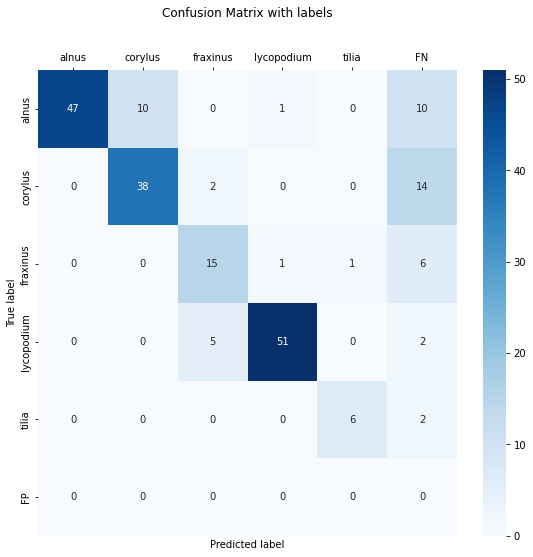

In [15]:
display(confusion_matrix, categories, OUTPUT_CONFUSION_DATA,METRICS_TITLE)
plot_confusion(confusion_matrix, categories,OUTPUT_CONFUSION_DATA)